In [8]:
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
from pycocotools import mask
from pycocotools.coco import COCO
%matplotlib inline

with open('../data/densepose/densepose_coco_2014_train.json', 'r') as f:
    train = json.load(f)

In [37]:
curr_ann = [a for a in train['annotations'] if a['id'] == 185913][0]

In [38]:
curr_ann['bbox']

[152.11, 183.1, 129.15, 375.97]

In [22]:
ann = train['annotations'][0]
ann['image_id']

262145

In [23]:
from skimage.io import imread
import cv2

img_path = f"/home/skorokhodov/densepose/coco/coco_train2014/COCO_train2014_{ann['image_id']:012d}.jpg"
img = imread(img_path)

In [24]:
def get_point_coords(ann, point_i):
    point = [ann['dp_x'][point_i], ann['dp_y'][point_i]]
    point[0] = ann['bbox'][0] + (point[0] / 256) * ann['bbox'][2]
    point[1] = ann['bbox'][1] + (point[1] / 256) * ann['bbox'][3]
    point = [int(p) for p in point]
    
    return point

In [26]:
# from collections import Counter
# Counter(ann['dp_I']).most_common()

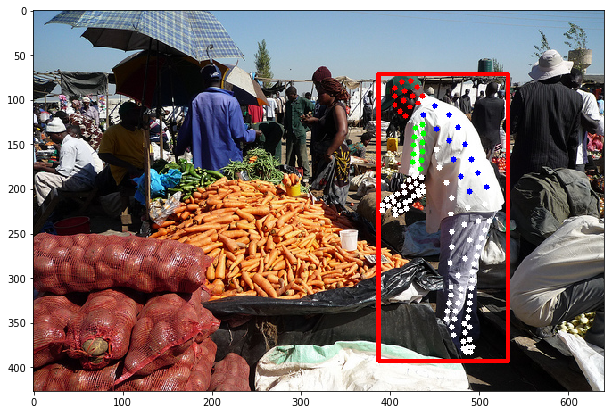

In [27]:
from skimage.io import imread
import cv2

img = imread(img_path)
bbox = [int(c) for c in ann['bbox']]
bbox = (bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3])
red = (255, 0, 0)
green = (0, 255, 0)
blue = (0, 0, 255)

cv2.rectangle(img, bbox[:2], bbox[2:], red, 3)

for i in range(len(ann['dp_I'])):
    point = get_point_coords(ann, i)
    label = ann['dp_I'][i]
    if label == 24:
        color = red
    elif label == 1:
        color = blue
    elif label == 17:
        color = green
    else:
        color = (255, 255, 255)
    cv2.rectangle(img, tuple(point), tuple(point), color, 5)

plt.figure(figsize=(15, 7))
plt.imshow(img)

In [20]:
max(ann['dp_U'])

0.9983125329017639

In [151]:
dummy_img = np.arange(300).reshape((10, 10, 3))

In [30]:
max(ann['dp_I'])

24.0

In [156]:
cv2.remap(dummy_img,
          np.array([0.1, 1.4, 2], dtype=np.float32),
          np.array([3, 4, 5], dtype=np.float32),
          cv2.INTER_NEAREST,
          borderMode=cv2.BORDER_CONSTANT,
          borderValue=0).transpose(2, 0, 1)

array([[[ 90],
        [123],
        [156]],

       [[ 91],
        [124],
        [157]],

       [[ 92],
        [125],
        [158]]], dtype=int32)

In [31]:
coco = COCO('../../densepose/coco/annotations/instances_train2014.json')

loading annotations into memory...
Done (t=18.55s)
creating index...
index created!


In [185]:
set(coco.annToMask(instances_train['annotations'][2]).ravel())

{0, 1}

In [159]:
with open('../../densepose/coco/annotations/instances_train2014.json', 'r') as f:
    instances_train = json.load(f)

In [170]:
set([k for a in instances_train['annotations'] for k in a.keys()])

{'area', 'bbox', 'category_id', 'id', 'image_id', 'iscrowd', 'segmentation'}

In [194]:
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision import transforms

In [209]:
coco_ds = CocoDetection('../../densepose/coco/coco_train2014/',
                        '../../densepose/coco/annotations/instances_train2014.json',
                        transform=transforms.ToTensor())

loading annotations into memory...
Done (t=12.40s)
creating index...
index created!


In [216]:
categories = [a['category_id'] for a in instances_train['annotations']]

In [210]:
dataloader = DataLoader(coco_ds, batch_size=1)

In [211]:
batch = next(iter(dataloader))

In [213]:
data = 

17

In [2]:
true_bbox = [358, 69, 941, 477]
pred_bbox = [275, 0, 900, 400]

In [5]:
res = {'prop': [[275.56964111328125, 0.0, 900.7421264648438, 401.17803955078125], [387.8759460449219, 52.397674560546875, 1013.449462890625, 639.9111328125], [427.1551513671875, 143.13031005859375, 788.372802734375, 479.44647216796875], [270.54345703125, 0.0, 1004.588623046875, 557.6026611328125], [454.38665771484375, 82.87567138671875, 825.4896850585938, 414.3874206542969], [459.0877685546875, 86.34013366699219, 1071.0, 450.99700927734375], [113.02462768554688, 77.12551879882812, 966.8062744140625, 469.4825134277344], [149.62612915039062, 145.18338012695312, 1039.4635009765625, 529.39208984375], [371.878662109375, 0.0, 792.23486328125, 478.8208312988281], [418.7109069824219, 131.63186645507812, 1071.0, 529.4486083984375], [358.36663818359375, 69.10459899902344, 941.1578979492188, 477.1046142578125]], 'true': [358.36663818359375, 69.10459899902344, 941.1578979492188, 477.1046142578125]}

In [7]:
for bbox in res['prop']:
    print(bb_intersection_over_union(true_bbox, bbox))

0.5852917103413308
0.594899843099604
0.5059423629558697
0.5817268762182599
0.5180051098981469
0.6165694275350193
0.6651434156706648
0.5013935316616651
0.6413723146782583
0.569705572795468
0.9985913598973797


In [33]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

bb_intersection_over_union((237.671875, 286.09375, 439.46875, 873.546875), (152.11, 183.1, 281.26, 559.07))

0.0782164913028516